In [1]:
import numpy as np
import torch

from botorch.test_functions import ZDT3
from botorch.utils.sampling import sample_simplex

from scalarize.utils.scalarization_functions import HypervolumeScalarization

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
def plot_histogram(edges, values, width, title):
    plt.bar(
        bin_edges[:-1],
        values,
        width=width,
        color="dodgerblue",
        edgecolor="black",
        linewidth=1,
    )
    plt.title(title, fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim([edges[0] - width, edges[-1]])
    return None

In [3]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
problem = ZDT3(negate=True, dim=2)

# data
num_samples = 9
x1 = torch.linspace(0, 1, num_samples, **tkwargs).unsqueeze(-1)
x2 = 0.5 * torch.ones(len(x1), **tkwargs)
x = torch.column_stack([x1, x2])
y = problem(x)

# scalarization function
ref_point = -1.1 * torch.ones(1, 2, **tkwargs)
weight = torch.tensor([[0.4, 0.6]], **tkwargs)
weight = weight / torch.norm(weight, p=2)
s_fn = HypervolumeScalarization(ref_points=ref_point, weights=weight)

sy = s_fn(y)
sy = torch.sort(sy, dim=-2).values

# mesh
N = 100
a = torch.linspace(-1.05, 0.05, N, **tkwargs)
X, Y = torch.meshgrid(a, a, indexing="xy")

Z = torch.zeros(X.shape, **tkwargs)
for j in range(N):
    Y_j = torch.column_stack([X[:, j], Y[:, j]])
    Z[:, j] = s_fn(Y_j).squeeze(-1)

In [4]:
# Reference
num_bins = 25
hist, bin_edges = np.histogram(sy, bins=num_bins)
width = bin_edges[1] - bin_edges[0]
normalized_hist = hist / num_samples

# Total variation
epsilon = 0.1
normalized_hist_tv = normalized_hist.copy()
normalized_hist_tv[0] = normalized_hist_tv[0] + epsilon
normalized_hist_tv[-1] = normalized_hist_tv[-1] - epsilon

# CVaR
normalized_hist_cvar = normalized_hist.copy()
alpha = 3 / num_samples
j = 0
for i in range(len(normalized_hist)):
    if normalized_hist[i] > 0 and j < alpha:
        normalized_hist_cvar[i] = 1 / alpha
        j += normalized_hist[i]
    else:
        normalized_hist_cvar[i] = 0
normalized_hist_cvar = normalized_hist_cvar / np.sum(normalized_hist_cvar)

# MCVaR
normalized_hist_mcvar = normalized_hist.copy()
b = 2
b_inv = 1 / b
normalized_hist_mcvar[normalized_hist_mcvar > 0] = 1 / num_samples
normalized_hist_mcvar = (
    b_inv * normalized_hist_mcvar + (1 - b_inv) * normalized_hist_cvar
)

In [5]:
# Approximate the best CS distribution using Lagrange solution

num_weights = int(1e8)
epsilon = 0.2

kappa = torch.linspace(-2, 2, num_weights, **tkwargs)
w = sy + kappa
w = w / torch.sum(w, dim=-2, keepdims=True)
means = torch.sum(w * sy, dim=-2)
c1 = torch.mean((num_samples * w - 1) ** 2, dim=-2) < epsilon
c2 = torch.all(w > 0, axis=-2).bool()
constraint = torch.logical_and(c1, c2)
w_star = w[:, constraint][:, torch.argmin(means[constraint])]

normalized_hist_chi = normalized_hist.copy()
normalized_hist_chi[normalized_hist_chi > 0] = w_star

In [6]:
# Approximate the best KL distribution using Lagrange solution

num_weights = int(1e8)
epsilon = -np.log(0.5)

kappa = torch.linspace(1e-8, 1, num_weights, **tkwargs)
w = torch.exp(-sy / kappa)
w = w / torch.sum(w, dim=-2, keepdims=True)

means = torch.sum(w * sy, dim=-2)
c1 = torch.mean(num_samples * w * torch.log(num_samples * w) ** 2, dim=-2) < epsilon
c2 = torch.all(w > 0, axis=-2).bool()
constraint = torch.logical_and(c1, c2)
w_star = w[:, constraint][:, torch.argmin(means[constraint])]

normalized_hist_kl = normalized_hist.copy()
normalized_hist_kl[normalized_hist_kl > 0] = w_star

C:\Users\Ben\AppData\Local\Temp\ipykernel_14156\1126102190.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, (1, 7))


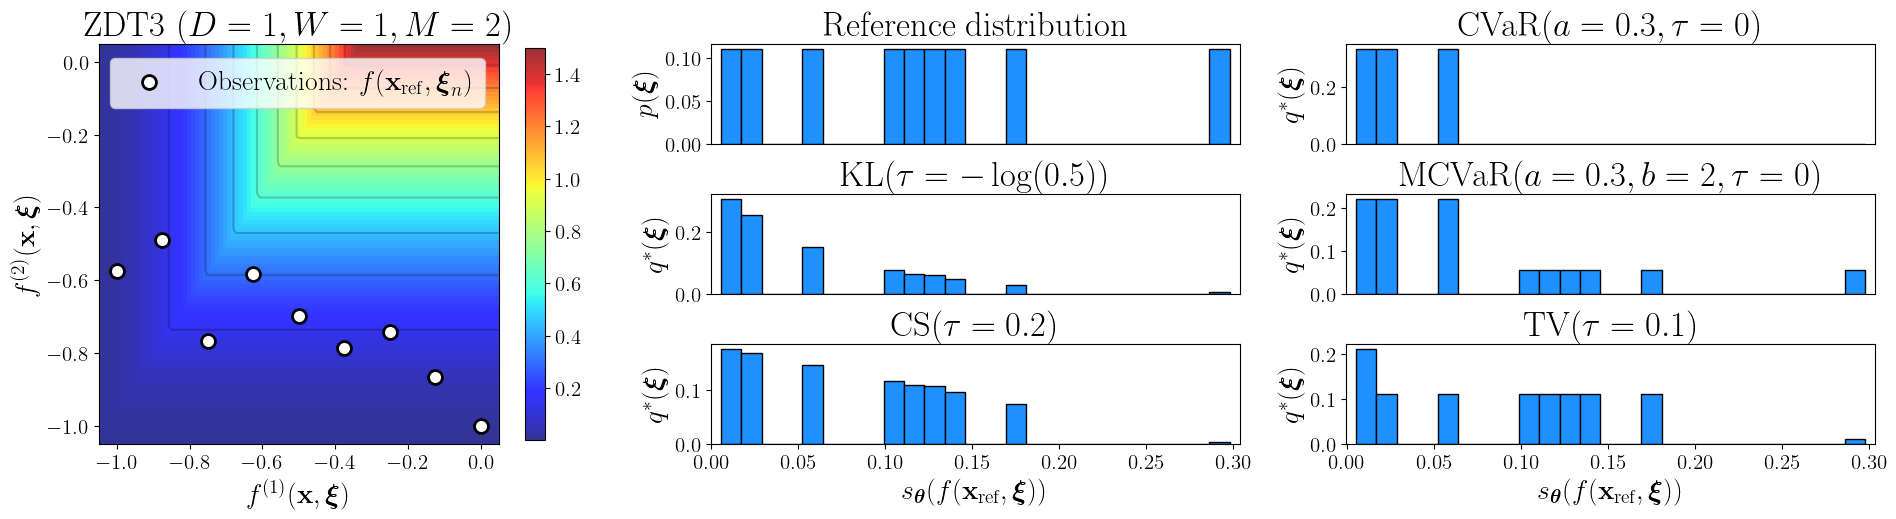

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(18, 4))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)

plt.subplot(3, 3, (1, 7))
plt.contour(X, Y, Z, 10, colors="black", alpha=0.2)
plt.imshow(Z, extent=[-1.05, 0.05, -1.05, 0.05], origin="lower", cmap="jet", alpha=0.8)
cbar = plt.colorbar(shrink=0.98)
cbar.ax.tick_params(labelsize=15)
plt.scatter(
    y[:, 0],
    y[:, 1],
    s=100,
    zorder=5,
    color="w",
    label=r"Observations: $f(\mathbf{x}_{\text{ref}}, \boldsymbol{\xi}_n)$",
    edgecolor="k",
    linewidth=2,
)

plt.xlim([-1.05, 0.05])
plt.ylim([-1.05, 0.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(r"$f^{(1)}(\mathbf{x}, \boldsymbol{\xi})$", fontsize=20)
plt.ylabel(r"$f^{(2)}(\mathbf{x}, \boldsymbol{\xi})$", fontsize=20)
plt.legend(fontsize=20)
plt.title(f"ZDT3 $(D=1, W=1, M=2)$", fontsize=25)

# Reference
plt.subplot(3, 3, 2)
plot_histogram(
    edges=bin_edges, values=normalized_hist, width=width, title="Reference distribution"
)
plt.ylabel(r"$p(\boldsymbol{\xi})$", fontsize=20)
plt.xticks([])

# CVaR
plt.subplot(3, 3, 3)
plot_histogram(
    edges=bin_edges,
    values=normalized_hist_cvar,
    width=width,
    title=r"CVaR$(a=0.3, \tau=0)$",
)
plt.ylabel(r"$q^*(\boldsymbol{\xi})$", fontsize=20)
plt.xticks([])

# KL
plt.subplot(3, 3, 5)
plot_histogram(
    edges=bin_edges,
    values=normalized_hist_kl,
    width=width,
    title=r"KL$(\tau=-\log(0.5))$",
)
plt.ylabel(r"$q^*(\boldsymbol{\xi})$", fontsize=20)
plt.xticks([])

# MCVaR
plt.subplot(3, 3, 6)
plot_histogram(
    edges=bin_edges,
    values=normalized_hist_mcvar,
    width=width,
    title=r"MCVaR$(a=0.3, b=2, \tau=0)$",
)
plt.ylabel(r"$q^*(\boldsymbol{\xi})$", fontsize=20)
plt.xticks([])

# CS
plt.subplot(3, 3, 8)
plot_histogram(
    edges=bin_edges, values=normalized_hist_chi, width=width, title=r"CS$(\tau=0.2)$"
)
plt.ylabel(r"$q^*(\boldsymbol{\xi})$", fontsize=20)
plt.xlabel(
    r"$s_{\boldsymbol{\theta}}(f(\mathbf{x}_{\text{ref}}, \boldsymbol{\xi}))$",
    fontsize=20,
)

# TV
plt.subplot(3, 3, 9)
plot_histogram(
    edges=bin_edges, values=normalized_hist_tv, width=width, title=r"TV$(\tau=0.1)$"
)
plt.ylabel(r"$q^*(\boldsymbol{\xi})$", fontsize=20)
plt.xlabel(
    r"$s_{\boldsymbol{\theta}}(f(\mathbf{x}_{\text{ref}}, \boldsymbol{\xi}))$",
    fontsize=20,
)

plt.show()